<a href="https://colab.research.google.com/github/BrainConnection/Dynamical_Decoupling_Project/blob/main/5.%20Measurement%20Induced%20Dephasing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Environment Setting



In [1]:
!pip install qutip
!pip install numpy
!pip install matplotlib
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 19.2 MB/s eta 0:00:00


In [2]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from scipy.optimize import curve_fit

#9. CP CPMG UDD XY4 XY8 XY16 UDD4 UDD8 UDD16 Sequence

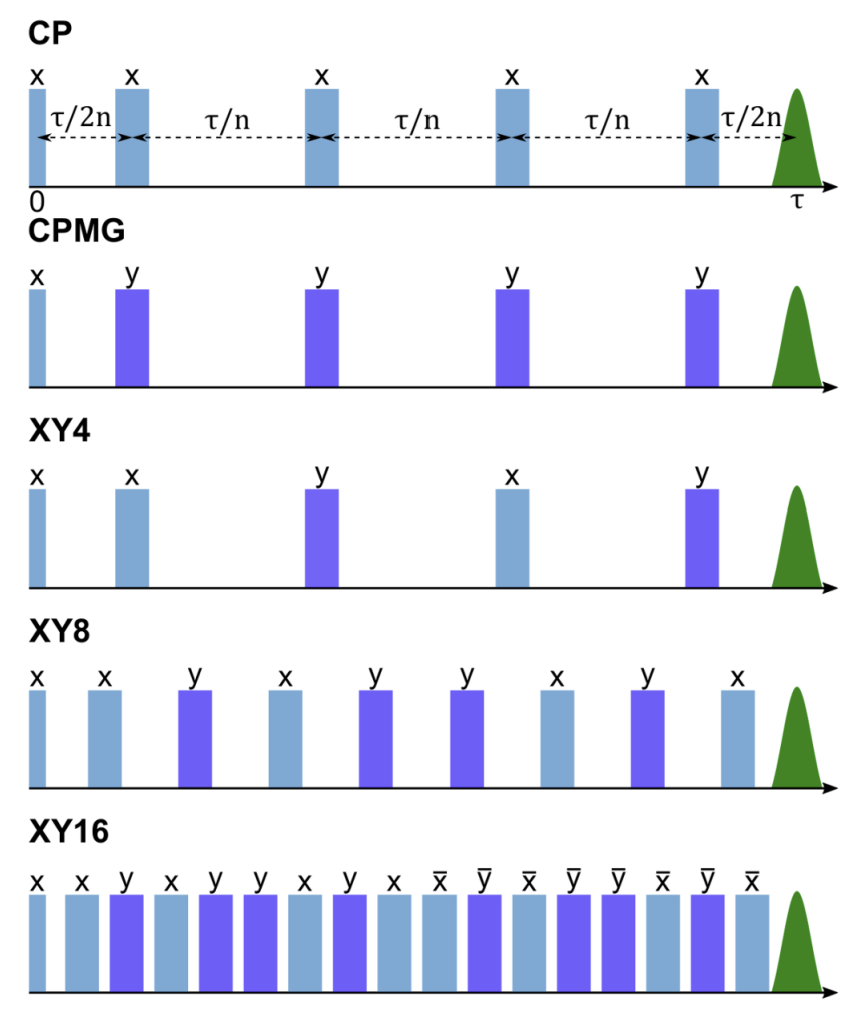

In [3]:
# Modulate each pulse timing (Equivalent Spacing)
# pulse list
# skip pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing(T_srt, T_end, N):

    T = T_end - T_srt
    Seq_list = []
    for i in range(N):
      Seq_list.append(T_srt + (2*i+1)*T/(2*N))

    Seq = np.array(Seq_list)

    return Seq


# Modulate each pulse timing (Sinusoidal Spacing)
# pulse list
# skip pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing_UDD(T_srt, T_end, N):

    T = T_end - T_srt
    Seq_list = []

    shift = 0
    for i in range(N):
      shift = shift + T * np.sin(np.pi/(2*(N+2))) * np.sin(np.pi*(i+1)/(N+2)) / np.cos(np.pi/(2*(N+2)))
      Seq_list.append(T_srt + shift)

    Seq = np.array(Seq_list)

    return Seq

In [4]:
# Single Square Pulse Envolope

def Single_pulse_env(t, B, T_cent):

    return B * (t > T_cent-0.5*np.pi/B) * (t < T_cent+0.5*np.pi/B)


# Single Square Pulse (lab frame)

def Single_pulse(t, B, Omega_qd, T_cent, Phi_qd):

    return Single_pulse_env(t, B, T_cent) * np.cos(Omega_qd * t + Phi_qd)

In [5]:
# time-dependent coefficient for resonator drive

def Hrd_rotating_frame(t, args):
    """
    Envelope function for the readout drive
    """
    A = args['A'] # amplitude of the readout drive
    T_srt = args['T_srt_r'] # duration of the readout drive, in units of ns
    T_end = args['T_end_r'] # duration of the readout drive, in units of ns

    return A * (T_srt <= t) * (t <= T_end)


def Hrd_lab_frame(t, args):
    omega_rd = args['Omega_rd']
    return Hrd_rotating_frame(t, args) * np.cos(omega_rd * t)

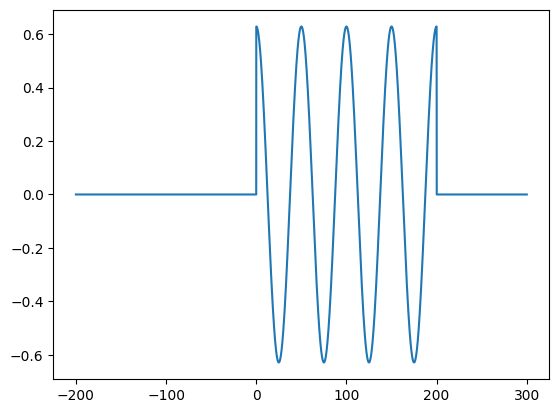

In [6]:
# resonator drive pulse simulation

tlist = np.linspace(-200, 300, 10000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*0.1, 'T_srt_r': 0, 'T_end_r': 200, 'Omega_rd': 2*np.pi*0.02}))

## CP CPMG UDD Sequence

In [7]:
# CP (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def CP_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N)
    pulse = 0

    for T_cent in Seq:
      pulse = pulse + Single_pulse(t, B, Omega_qd, T_cent, 0)

    return pulse

In [8]:
# CPMG (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def CPMG_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N)
    pulse = 0

    for T_cent in Seq:
      pulse = pulse + Single_pulse(t, B, Omega_qd, T_cent, 0.5*np.pi)

    return pulse

In [9]:
# CPMG (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def UDD_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_UDD(T_srt, T_end, N)
    pulse = 0

    for T_cent in Seq:
      pulse = pulse + Single_pulse(t, B, Omega_qd, T_cent, 0.5*np.pi)

    return pulse

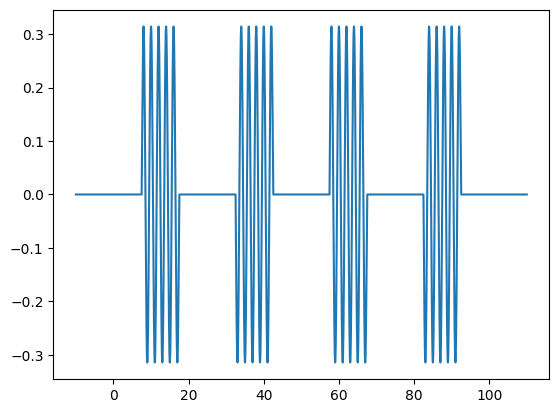

In [10]:
# qubit drive pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, CP_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 4, 'Omega_qd': 2*np.pi*0.5}))

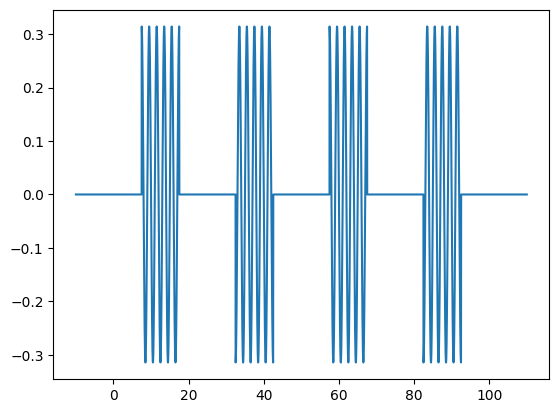

In [11]:
# qubit drive pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, CPMG_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 4, 'Omega_qd': 2*np.pi*0.5}))

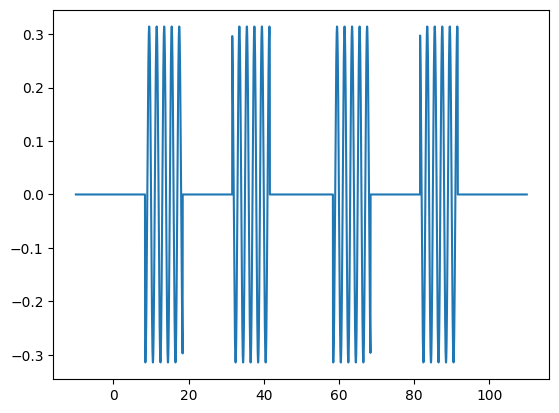

In [12]:
# qubit drive pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, UDD_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 4, 'Omega_qd': 2*np.pi*0.5}))

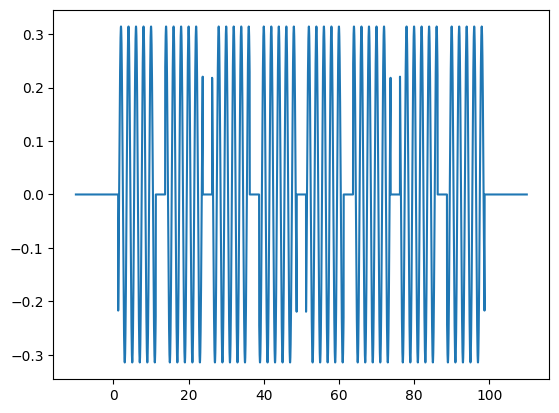

In [13]:
# qubit drive pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, CP_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 8, 'Omega_qd': 2*np.pi*0.5}))

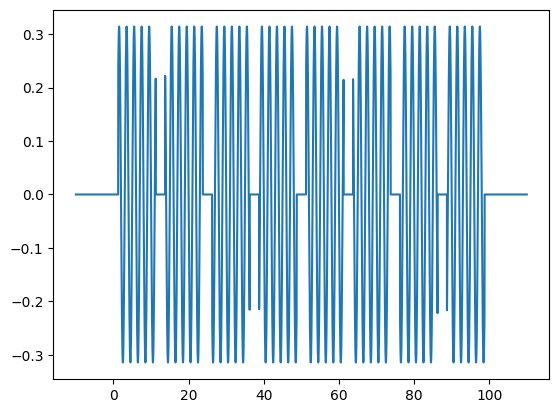

In [14]:
# qubit drive pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, CPMG_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 8, 'Omega_qd': 2*np.pi*0.5}))

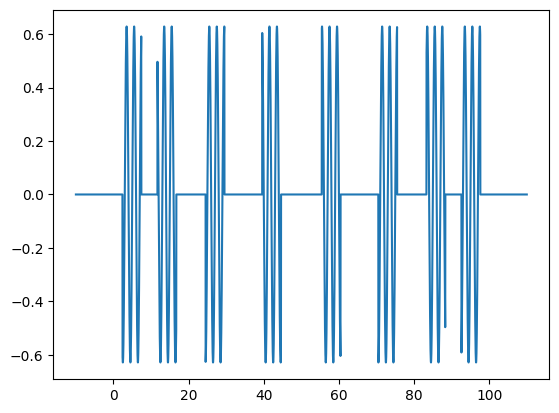

In [15]:
# qubit drive pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, UDD_lab_frame(tlist, {'B': 2*np.pi*0.1, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 8, 'Omega_qd': 2*np.pi*0.5}))

## XY4 XY8 XY16 Sequence

In [16]:
# XY4 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY4_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 4)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    return pulse

In [17]:
# XY8 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY8_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 8)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 0)

    return pulse

In [18]:
# XY16 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY16_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 16)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 0)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[8], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[9], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[10], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[11], 1.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[12], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[13], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[14], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[15], np.pi)

    return pulse

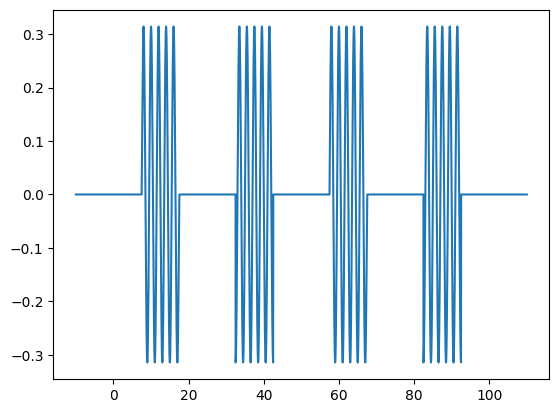

In [19]:
# qubit pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, XY4_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'Omega_qd': 2*np.pi*0.5}))

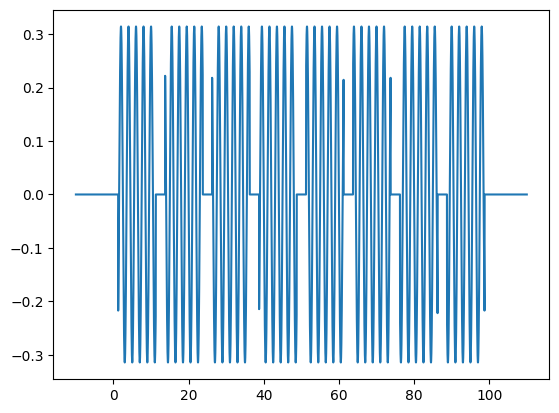

In [20]:
# qubit pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, XY8_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'Omega_qd': 2*np.pi*0.5}))

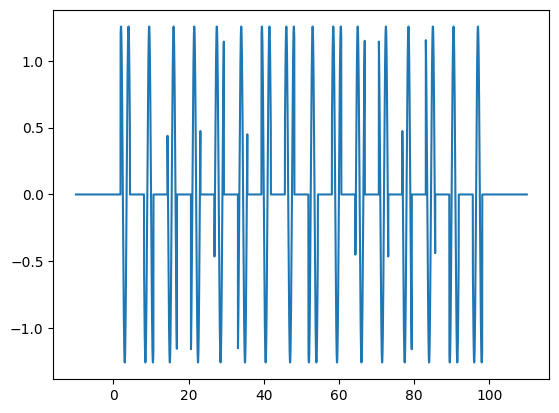

In [21]:
# qubit pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, XY16_lab_frame(tlist, {'B': 2*np.pi*0.2, 'T_srt_q': 0, 'T_end_q': 100, 'Omega_qd': 2*np.pi*0.5}))

## UDD4 UDD8 UDD16 Sequence

In [22]:
# UDD4 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def UDD4_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_UDD(T_srt, T_end, 4)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    return pulse

In [23]:
# UDD8 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def UDD8_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_UDD(T_srt, T_end, 8)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 0)

    return pulse

In [24]:
# UDD16 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def UDD16_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_UDD(T_srt, T_end, 16)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 0)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[8], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[9], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[10], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[11], 1.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[12], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[13], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[14], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[15], np.pi)

    return pulse

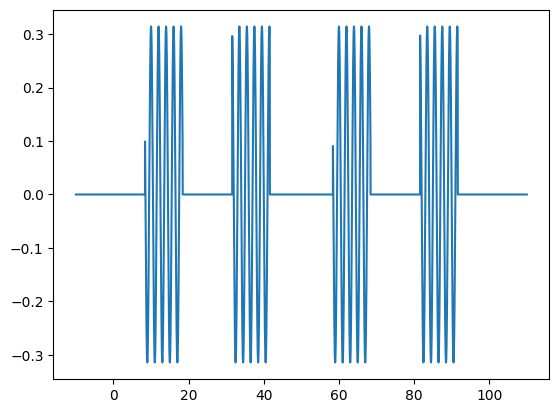

In [25]:
# qubit pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, UDD4_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'Omega_qd': 2*np.pi*0.5}))

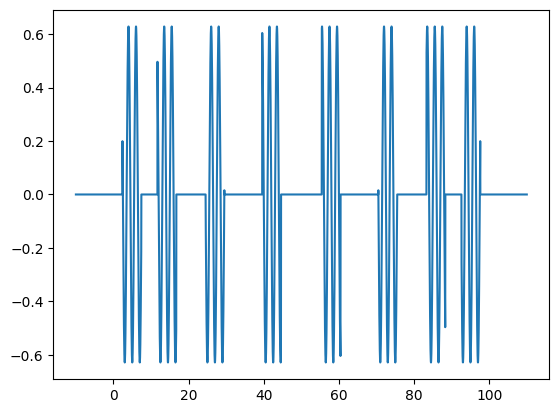

In [26]:
# qubit pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, UDD8_lab_frame(tlist, {'B': 2*np.pi*0.1, 'T_srt_q': 0, 'T_end_q': 100, 'Omega_qd': 2*np.pi*0.5}))

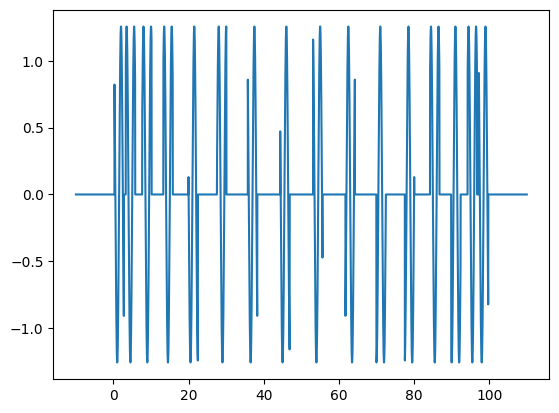

In [27]:
# qubit pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, UDD16_lab_frame(tlist, {'B': 2*np.pi*0.2, 'T_srt_q': 0, 'T_end_q': 100, 'Omega_qd': 2*np.pi*0.5}))

#10. Purcell Filter

## Without Purcell Filter

### Hamiltonian & System Setting

$ H_0 = -\frac{\omega_q}{2}\sigma_z + \omega_r a^\dagger a + g\sigma_x(a+a^\dagger) $

$ H_1 = A(t) (\hat{a} + \hat{a}^\dagger) \cos{(\omega_d t ) } $

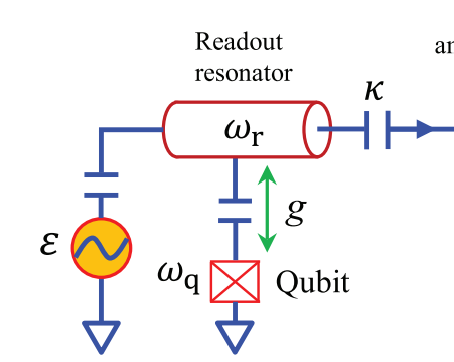

In [ ]:
# constant

N = 5                       # resonator Hilbert Space size

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01    # external coupling rate of resonator in units of GHz

In [ ]:
# operator

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()

a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2p = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))


H0 = -0.5*omega_q*tensor(sz, qeye(N)) + omega_r*tensor(qeye(2), a.dag()*a) + g*tensor(sx, a + a.dag())

In [ ]:
# time-dependent coefficient for drive
def Hrd_env(t, args):
    """
    Envelope function for the readout drive
    """
    A = args['A'] # amplitude of the readout drive
    T = args['T'] # duration of the readout drive, in units of ns

    return A * (0 <= t) * (t <= T)

def Hrd_coeff(t, args):
    omega_rd = args['omega_rd']
    return Hrd_env(t, args) * np.cos(omega_rd * t)

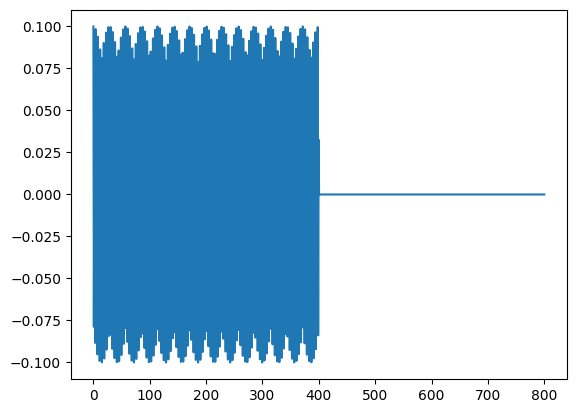

In [ ]:
# list of times for numerical simulation (in units of ns)
tlist = np.linspace(0, 800, 1000)
plt.figure()
plt.plot(tlist, Hrd_coeff(tlist, {'A': 0.1, 'T': 400, 'omega_rd': omega_rd}))

### Time Evolution & Purcell Decay Rate

Initialize the qubit to the 1 state and drive coherent photon to resonator.

Coherent photon number is $n=0.23$.

Qubit decay channel according to coupling of qubit and resonator makes qubit's longitudinal relaxation

In [ ]:
# time evolution

tlist = np.linspace(0, 5000, 50000)

result = mesolve(
    [H0, [tensor(qeye(2), a+a.dag()), Hrd_coeff]],
    psi_21,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 0.01 * 2 * np.pi, 'T': 5000, 'omega_rd': omega_rd},
    e_ops = op_list,
)

result.expect[4][-1]

0.2294269055141213

Text(0, 0.5, 'Photon Number Expectation Value')

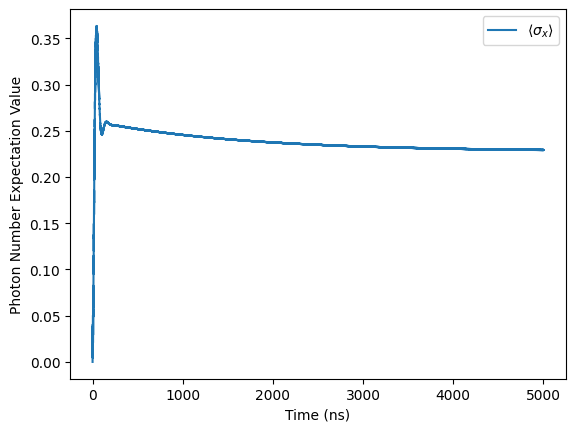

In [ ]:
# Plot Readout Resonator Photon Number

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result.expect[4], label = r'$\langle\sigma_x\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

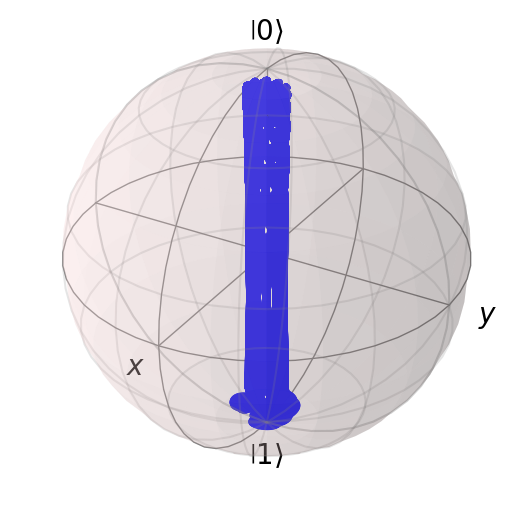

In [ ]:
# Bloch Sphere

sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

Text(0, 0.5, 'Expectation Value')

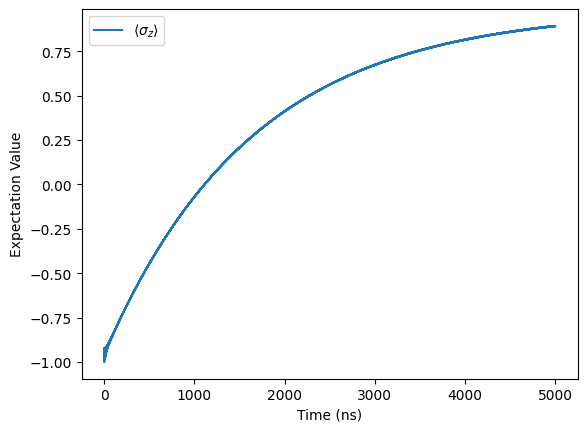

In [ ]:
# Plot Z expectation value to extract T1 time

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

In [ ]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-1.94050834e+00,  9.83417385e-01,  1.63749690e+03])

Measured $ T_1 = 1.637 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

### Time Evolution & Purcell Decay Rate

Initialize the qubit to the 1 state and drive coherent photon to resonator.

Coherent photon number is $n=0.0023$.

The Purcell decay rate is independent of the readout resonator photon number.

In [ ]:
# time evolution

tlist = np.linspace(0, 5000, 50000)

result = mesolve(
    [H0, [tensor(qeye(2), a+a.dag()), Hrd_coeff]],
    psi_21,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 0.001 * 2 * np.pi, 'T': 5000, 'omega_rd': omega_rd},
    e_ops = op_list,
)

result.expect[4][-1]

0.0028341395379163498

Text(0, 0.5, 'Photon Number Expectation Value')

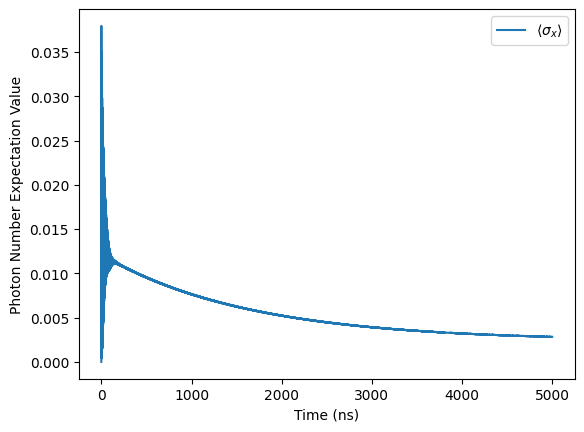

In [ ]:
# Plot Photon Number

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result.expect[4], label = r'$\langle\sigma_x\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

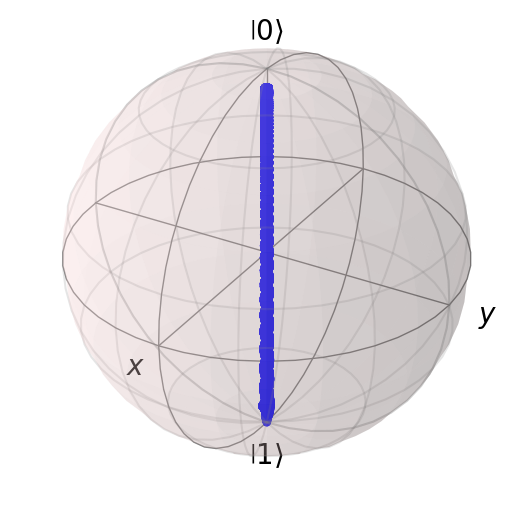

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

Text(0, 0.5, 'Expectation Value')

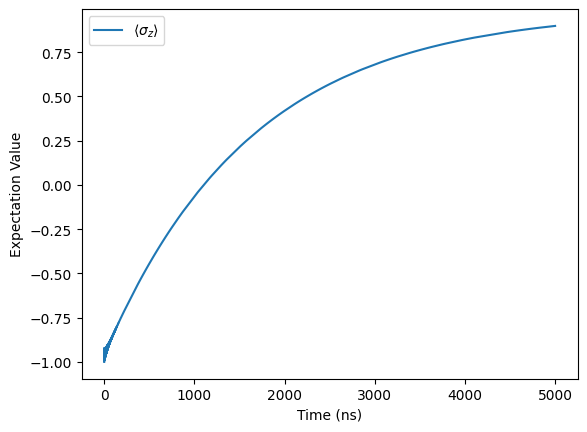

In [ ]:
# Plot Z expectation value to extract T1 time

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

In [ ]:
# Fitting function : exponential function

def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-1.94916020e+00,  9.87956330e-01,  1.62476298e+03])

Measured $ T_1 = 1.629 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa \frac{g^2}{\Delta^2} = 0.000628 GHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 1.637 \mu s$

## With Linear Purcell Filter

### Hamiltonian & System Setting

$ H_0 = -\frac{\omega_q}{2}\sigma_z + \omega_r a^\dagger a + \omega_f b^\dagger b + g(\sigma_+a+\sigma_-a^\dagger) + G(a b^\dagger + a^\dagger b)$

$ H_1 = A(t) (\hat{a} + \hat{a}^\dagger) \cos{(\omega_{rd} t ) } $

Coupling of Readout Resonator & Filter Resonator

Purcell Filter acts like a bandpass filter,

which only suppress qubit relaxation rate but keep measurement rate

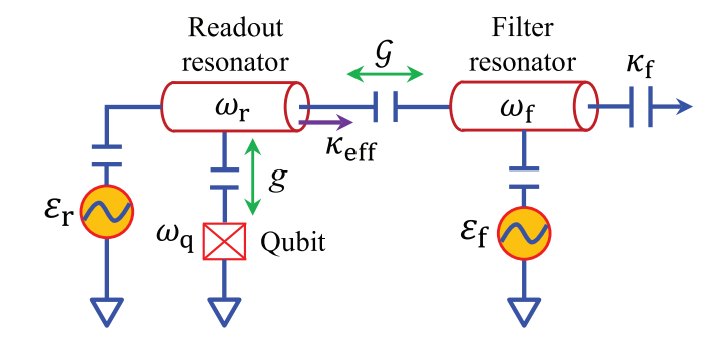

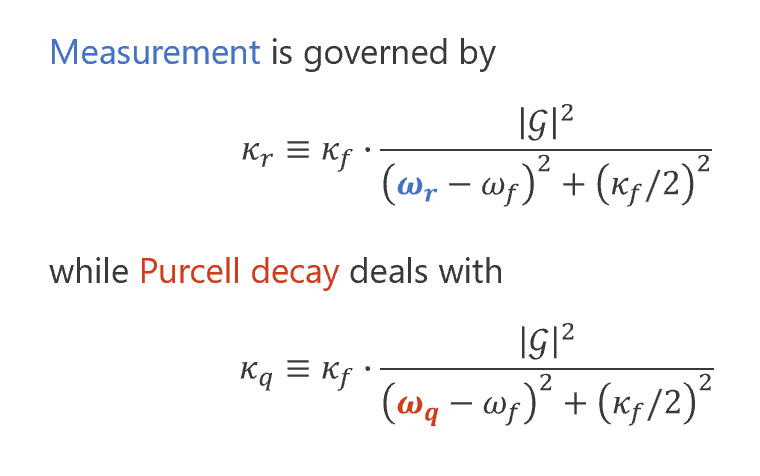

In [ ]:
# constant
N = 2

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.2         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

In [ ]:
# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2p = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))

In [ ]:
# time-dependent coefficient for drive
def Hrd_env(t, args):
    """
    Envelope function for the readout drive
    """
    A = args['A'] # amplitude of the readout drive
    T = args['T'] # duration of the readout drive, in units of ns

    return A * (0 <= t) * (t <= T)

def Hrd_coeff(t, args):
    omega_rd = args['omega_rd']
    return Hrd_env(t, args) * np.cos(omega_rd * t)

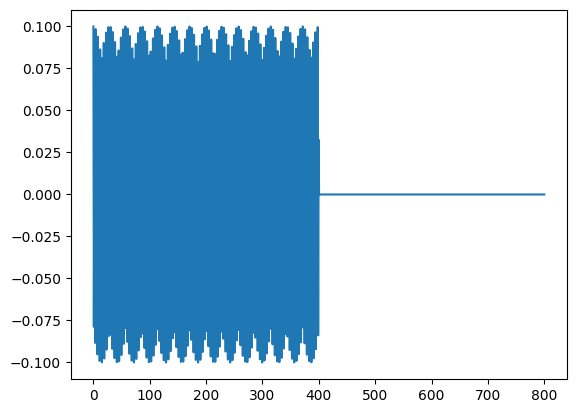

In [ ]:
# list of times for numerical simulation (in units of ns)
tlist = np.linspace(0, 800, 1000)
plt.figure()
plt.plot(tlist, Hrd_coeff(tlist, {'A': 0.1, 'T': 400, 'omega_rd': omega_rd}))

### Time Evolution & Purcell Decay Rate

Initialize the qubit to the 1 state and drive coherent photon to resonator.

Coherent photon number is $n=0.40$.

Let $\omega_f=\omega_{rd}$ such that detune between drive frequency and filter resonator frequency be zero, but detune between qubit frequency and filter resonator frequency be 1GHz,

which means that qubit's relaxation rate is filted by purcell filter, but measurement rate is not filted.

In [ ]:
tlist = np.linspace(0, 5000, 50000)

result = mesolve(
    [H0, [tensor(qeye(2), a+a.dag(), qeye(N)), Hrd_coeff]],
    psi_21,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': 0.1 * 2 * np.pi, 'T': 5000, 'omega_rd': omega_rd},
    e_ops = op_list,
)

result.expect[4][-1]

0.4085568310511106

Text(0, 0.5, 'Photon Number Expectation Value')

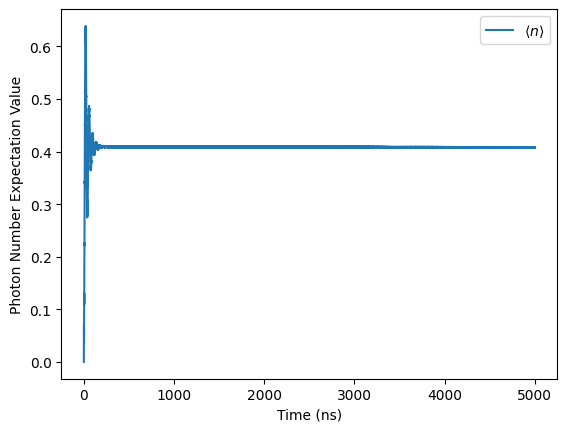

In [ ]:
# Plot Readout Resonator Photon Number

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result.expect[4], label = r'$\langle n \rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

Text(0, 0.5, 'Photon Number Expectation Value')

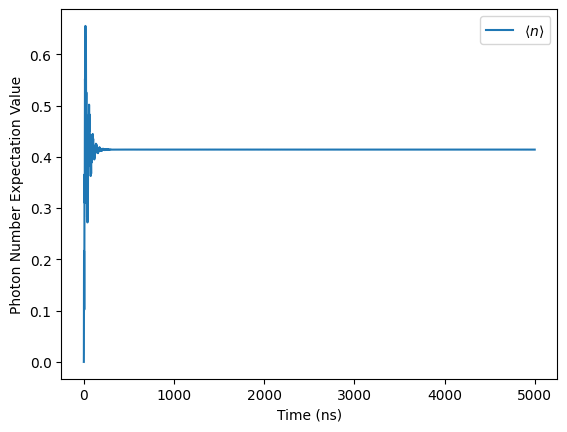

In [ ]:
# Plot Filter Resonator Photon Number

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result.expect[5], label = r'$\langle n \rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

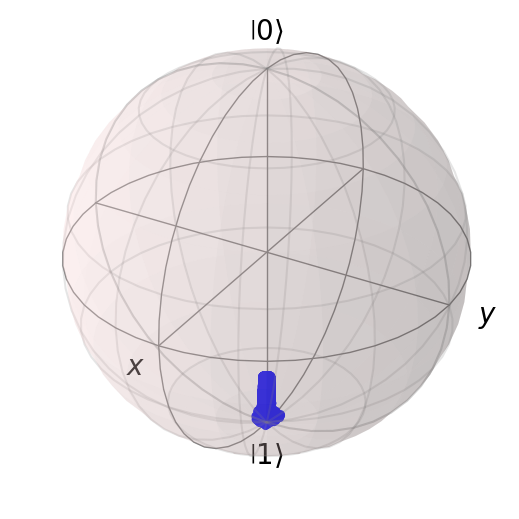

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

Text(0, 0.5, 'Expectation Value')

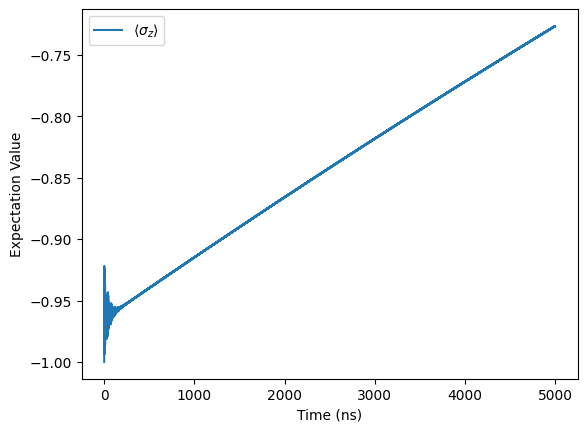

In [ ]:
# Plot Z

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

In [ ]:
def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-1.93849729e+00,  9.73398223e-01,  3.80794172e+04])

Measured $ T_1 = 38.079 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa_f \frac{g^2}{\Delta_{rq}^2}\frac{G^2}{\Delta_{fq}^2+(\frac{\kappa_f}{2})^2} = 0.025 MHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 39.790 \mu s$

### Time Evolution & Purcell Decay Rate

Initialize the qubit to the 1 state and drive coherent photon to resonator.

Coherent photon number is $n=0.009$.

Let $\omega_f=\omega_{rd}$ such that detune between drive frequency and filter resonator frequency be zero, but detune between qubit frequency and filter resonator frequency be 1GHz,

which means that qubit's relaxation rate is filted by purcell filter, but measurement rate is not filted.

Purcell Decay rate is independent of readout resonator photon number

In [ ]:
tlist = np.linspace(0, 5000, 50000)

result = mesolve(
    [H0, [tensor(qeye(2), a+a.dag(), qeye(N)), Hrd_coeff]],
    psi_21,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': 0.001 * 2 * np.pi, 'T': 5000, 'omega_rd': omega_rd},
    e_ops = op_list,
)

result.expect[4][-1]

0.009123734913412862

Text(0, 0.5, 'Photon Number Expectation Value')

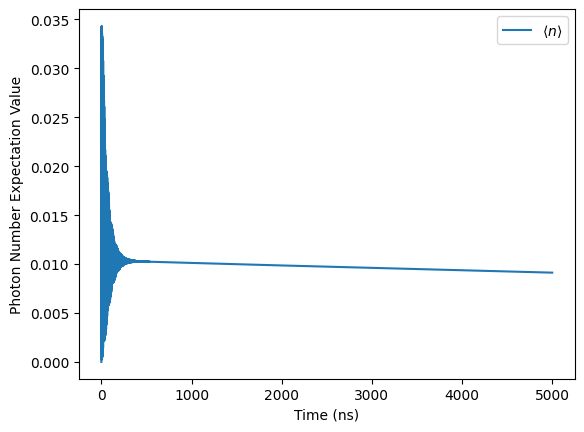

In [ ]:
# Plot Readout Resonator Photon Number

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result.expect[4], label = r'$\langle n \rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

Text(0, 0.5, 'Photon Number Expectation Value')

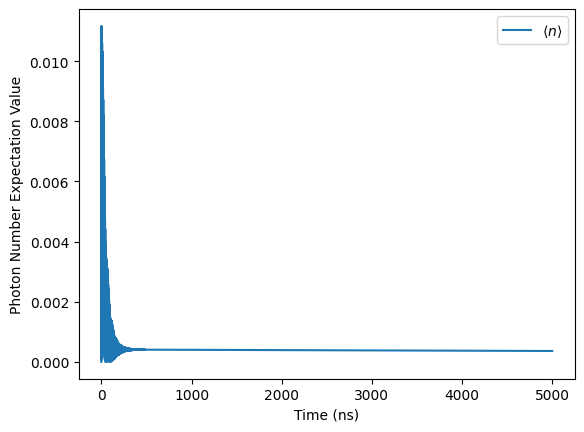

In [ ]:
# Plot Filter Resonator Photon Number

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result.expect[5], label = r'$\langle n \rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

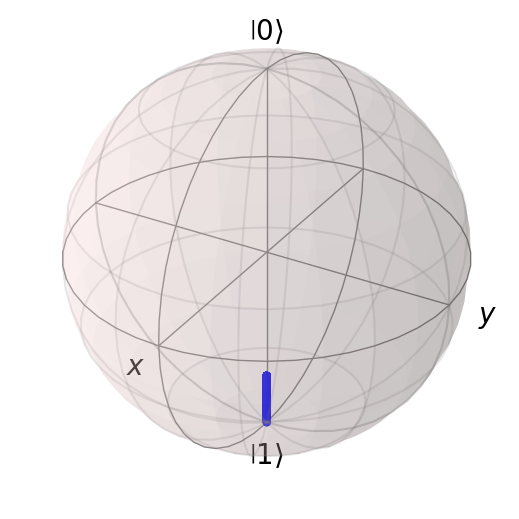

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

Text(0, 0.5, 'Expectation Value')

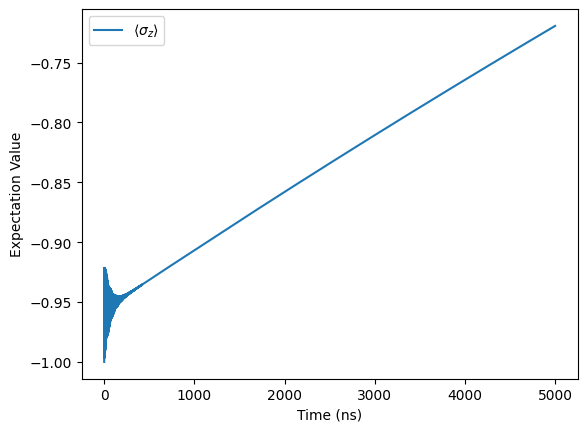

In [ ]:
# Plot Z

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

In [ ]:
def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-1.95662783e+00,  1.00002242e+00,  3.86919330e+04])

Measured $ T_1 = 38.692 \mu s$

Calculated Purcell Decay Rate $ \Gamma_{purcell} = \kappa_f \frac{g^2}{\Delta_{rq}^2}\frac{G^2}{\Delta_{fq}^2+(\frac{\kappa_f}{2})^2} = 0.025 MHz $

Calculated $ T_1 = \frac{1}{\Gamma_{purcell}} = 39.790 \mu s$

### Time Evolution & Purcell Decay Rate

Initialize the qubit to the 1 state and drive coherent photon to resonator.

Coherent photon number is $n=0.347$.

Let $\omega_f=\omega_q$ such that detune between drive frequency and filter resonator frequency be 1GHz, but detune between qubit frequency and filter resonator frequency be zero,

which means that qubit's relaxation rate is not filted by purcell filter.

Detune between qubit frequency and filter resonator frequency is important for suppressing Purcell decay rate.

In [ ]:
# constant
N = 2

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 6.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.2         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2p = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))

In [ ]:
tlist = np.linspace(0, 5000, 50000)

result = mesolve(
    [H0, [tensor(qeye(2), a+a.dag(), qeye(N)), Hrd_coeff]],
    psi_21,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': 0.1 * 2 * np.pi, 'T': 5000, 'omega_rd': omega_rd},
    e_ops = op_list,
)

result.expect[4][-1]

0.34755218715049707

Text(0, 0.5, 'Photon Number Expectation Value')

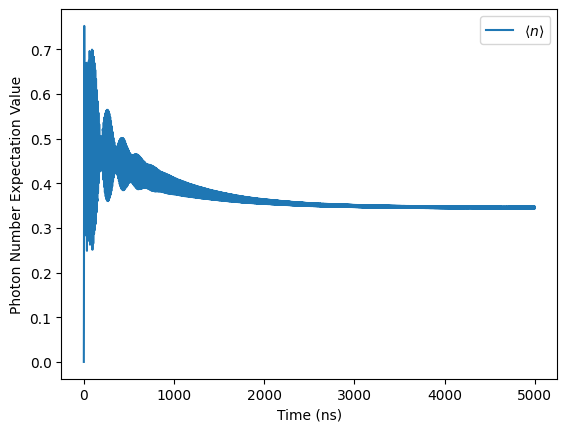

In [ ]:
# Plot Readout Resonator Photon Number

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result.expect[4], label = r'$\langle n \rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

Text(0, 0.5, 'Photon Number Expectation Value')

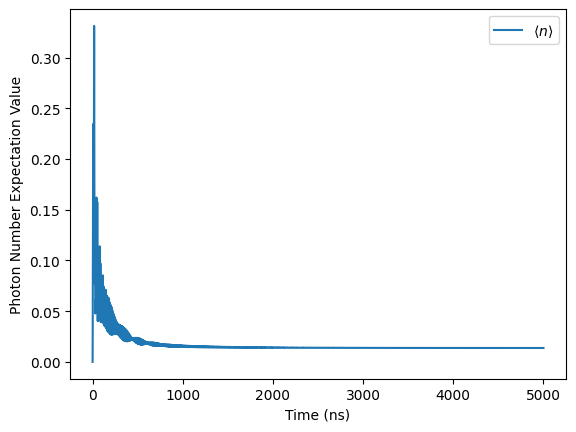

In [ ]:
# Plot Filter Resonator Photon Number

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result.expect[5], label = r'$\langle n \rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

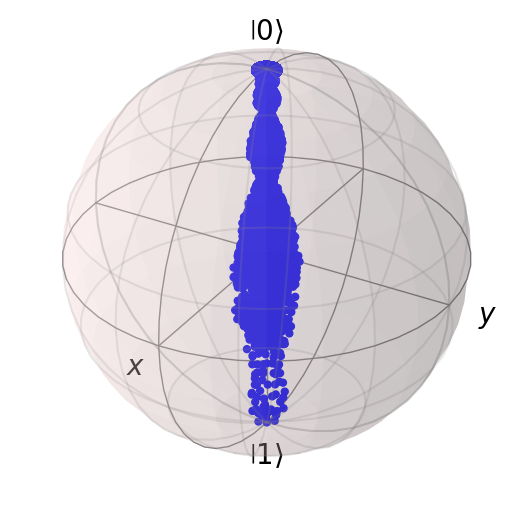

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

Text(0, 0.5, 'Expectation Value')

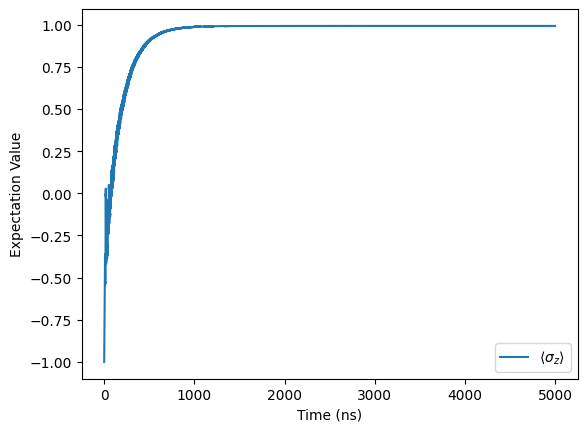

In [ ]:
# Plot Z

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

In [ ]:
def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([ -1.46830138,   0.99296759, 177.97432651])

Measured $ T_1 = 177.97 ns$

### Time Evolution & Purcell Decay Rate

$\omega_f=\omega_q$

$n=0.01$

In [ ]:
# constant
N = 2

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 6.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.2         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2p = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))

In [ ]:
tlist = np.linspace(0, 5000, 50000)

result = mesolve(
    [H0, [tensor(qeye(2), a+a.dag(), qeye(N)), Hrd_coeff]],
    psi_21,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': 0.01 * 2 * np.pi, 'T': 5000, 'omega_rd': omega_rd},
    e_ops = op_list,
)

result.expect[4][-1]

0.010370378614427654

Text(0, 0.5, 'Photon Number Expectation Value')

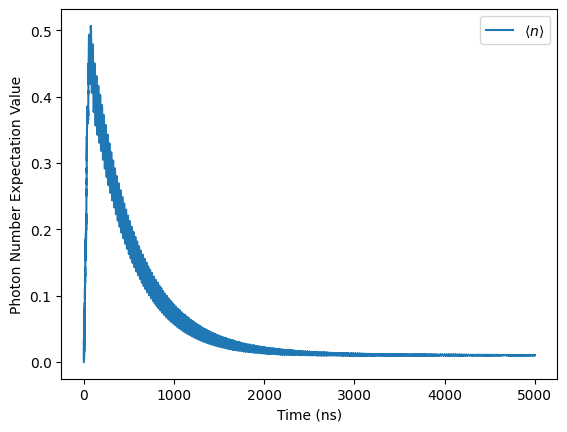

In [ ]:
# Plot Readout Resonator Photon Number

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result.expect[4], label = r'$\langle n \rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

Text(0, 0.5, 'Photon Number Expectation Value')

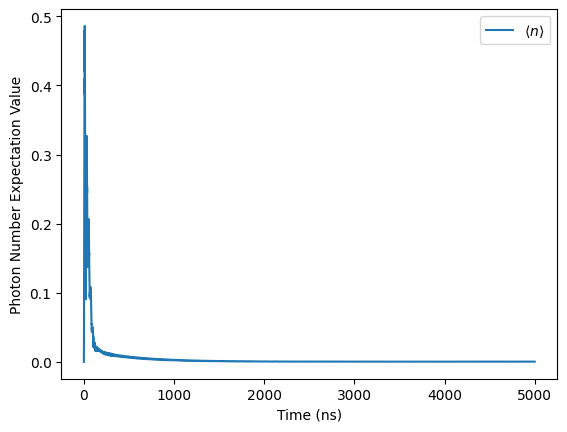

In [ ]:
# Plot Filter Resonator Photon Number

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result.expect[5], label = r'$\langle n \rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

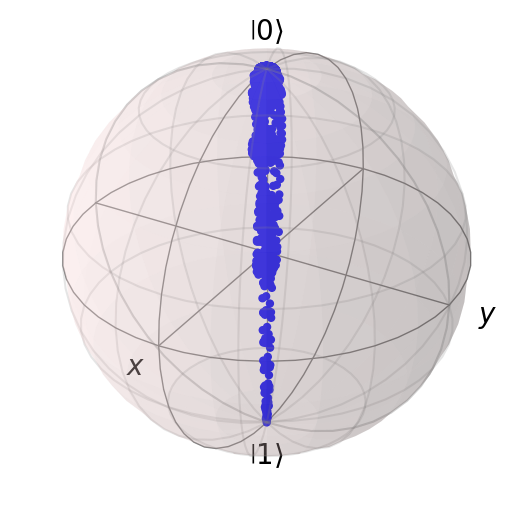

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([result.expect[0], result.expect[1], result.expect[2]]), meth="s")
sphere.show()

Text(0, 0.5, 'Expectation Value')

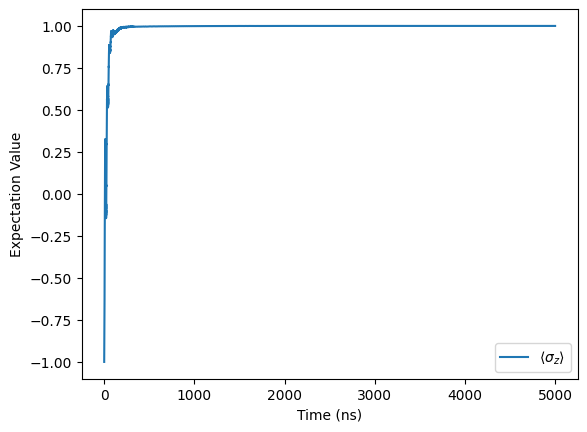

In [ ]:
# Plot Z

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result.expect[2], label = r'$\langle\sigma_z\rangle$')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

In [ ]:
def func(t, a, b, tau):
  return a*np.exp(-t/tau) + b

zlist = result.expect[2]
popt, pcov = curve_fit(func, tlist[2500:], zlist[2500:], p0 = [-1.5, 1, 10000/(2 * np.pi)])

popt

array([-1.04487802e-02,  9.99785003e-01,  4.38769779e+02])

Measured $ T_1 = 438.76 ns$

## Effective Linewidth Calculation

In [28]:
kappa_simulation = []
rphoton_simulation = []
pphoton_simulation = []
oscillation_simulation = []

### $ \kappa = 2\pi 2MHz$ $G=2\pi 10MHz$

In [40]:
# readout resonator & purcell filter resonator dimension

N = 3


# constant

B = 0.01 * 2 * np.pi        # gate operation time : 50ns

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.10        # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.002  # external coupling rate of resonator in units of GHz
kappa_r = 2 * np.pi * 0.00  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi

# operator defined on bare basis

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_bare                 = tensor(sx, qeye(N), qeye(N))
sy_bare                 = tensor(sy, qeye(N), qeye(N))
sz_bare                 = tensor(sz, qeye(N), qeye(N))
sp_bare                 = tensor(sp, qeye(N), qeye(N))
sm_bare                 = tensor(sm, qeye(N), qeye(N))

readout_annihilate_bare = tensor(qeye(2), a, qeye(N))
readout_create_bare     = tensor(qeye(2), a.dag(), qeye(N))
readout_number_bare     = tensor(qeye(2), a.dag()*a, qeye(N))

filter_annihilate_bare  = tensor(qeye(2), qeye(N), b)
filter_create_bare      = tensor(qeye(2), qeye(N), b.dag())
filter_number_bare      = tensor(qeye(2), qeye(N), b.dag()*b)

psi0_bare               = tensor(basis(2,0), basis(N,0), basis(N,0))
psis_bare               = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi1_bare               = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_bare + omega_r*readout_number_bare + omega_f*filter_number_bare + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_bare

tot_coherence_list_2 = []
tau_list = np.array([100*(k+3) for k in range(8)])

In [41]:
sx_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ (-1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ (-1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + (-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ (-1j)*H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + (-1j)*H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ (-1j)*H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ (+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + (+1j)*H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ (+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + (+1j)*H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ (+1j)*H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + (+1j)*H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ (+1j)*H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
- H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() - H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
- H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() - H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
- H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()


sp_dressed = H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


readout_number_dressed = H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 2*H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
+ 2*H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + 2*H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag() \


filter_number_dressed = H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 2*H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() \
+ 2*H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + 2*H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()

In [42]:
psi0_dressed             = H0.eigenstates()[1][0]
psi1_dressed             = H0.eigenstates()[1][1]
psis_dressed             = (psi0_dressed + psi1_dressed)/np.sqrt(2)

op_list = [sx_dressed, sy_dressed, sz_dressed, sp_dressed, readout_number_dressed, filter_number_dressed, readout_number_bare, filter_number_bare]

In [43]:
# Simulation

N_seq = 0
A = 0.0001 * 2 * np.pi
omega_qd = 37.6381

tlist = np.linspace(0, 1000, 1000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi1_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

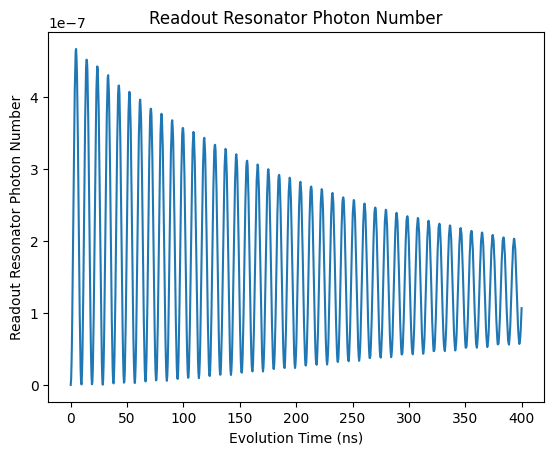

In [44]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Filter Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Filter Resonator Photon Number')

In [45]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[4], p0 = [0.02, 0.0628, 0.012])

popt

array([1.18506474e-07, 6.62900171e-01, 5.98575263e-03])

In [46]:
kappa_simulation.append(popt[2])

### $ \kappa = 2\pi 2MHz$ $G=2\pi 20MHz$

In [54]:
# readout resonator & purcell filter resonator dimension

N = 3


# constant

B = 0.01 * 2 * np.pi        # gate operation time : 50ns

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.20        # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.002  # external coupling rate of resonator in units of GHz
kappa_r = 2 * np.pi * 0.00  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi

# operator defined on bare basis

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_bare                 = tensor(sx, qeye(N), qeye(N))
sy_bare                 = tensor(sy, qeye(N), qeye(N))
sz_bare                 = tensor(sz, qeye(N), qeye(N))
sp_bare                 = tensor(sp, qeye(N), qeye(N))
sm_bare                 = tensor(sm, qeye(N), qeye(N))

readout_annihilate_bare = tensor(qeye(2), a, qeye(N))
readout_create_bare     = tensor(qeye(2), a.dag(), qeye(N))
readout_number_bare     = tensor(qeye(2), a.dag()*a, qeye(N))

filter_annihilate_bare  = tensor(qeye(2), qeye(N), b)
filter_create_bare      = tensor(qeye(2), qeye(N), b.dag())
filter_number_bare      = tensor(qeye(2), qeye(N), b.dag()*b)

psi0_bare               = tensor(basis(2,0), basis(N,0), basis(N,0))
psis_bare               = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi1_bare               = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_bare + omega_r*readout_number_bare + omega_f*filter_number_bare + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_bare

tot_coherence_list_2 = []
tau_list = np.array([100*(k+3) for k in range(8)])

In [55]:
sx_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ (-1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ (-1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + (-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ (-1j)*H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + (-1j)*H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ (-1j)*H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ (+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + (+1j)*H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ (+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + (+1j)*H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ (+1j)*H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + (+1j)*H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ (+1j)*H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
- H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() - H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
- H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() - H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
- H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()


sp_dressed = H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


readout_number_dressed = H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 2*H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
+ 2*H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + 2*H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag() \


filter_number_dressed = H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 2*H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() \
+ 2*H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + 2*H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()

In [56]:
psi0_dressed             = H0.eigenstates()[1][0]
psi1_dressed             = H0.eigenstates()[1][1]
psis_dressed             = (psi0_dressed + psi1_dressed)/np.sqrt(2)

op_list = [sx_dressed, sy_dressed, sz_dressed, sp_dressed, readout_number_dressed, filter_number_dressed, readout_number_bare, filter_number_bare]

In [57]:
# Simulation

N_seq = 0
A = 0.0001 * 2 * np.pi
omega_qd = 37.6381

tlist = np.linspace(0, 400, 1000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi1_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

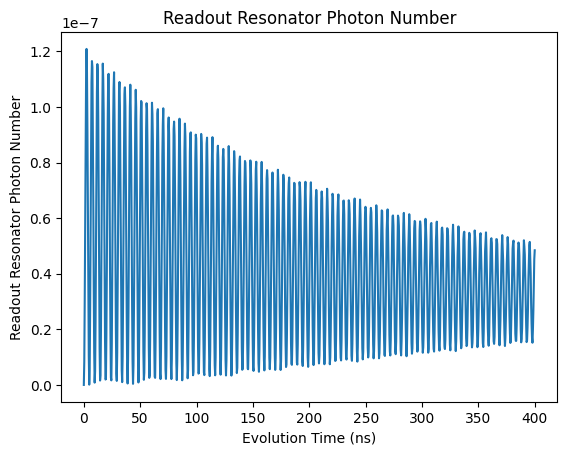

In [58]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Filter Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Filter Resonator Photon Number')

In [59]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[4], p0 = [0.02, 0.0628, 0.012])

popt

array([3.03922358e-08, 1.29496168e+00, 6.18000087e-03])

In [60]:
kappa_simulation.append(popt[2])

### $ \kappa = 2\pi 2MHz$ $G=2\pi 30MHz$

In [ ]:
# readout resonator & purcell filter resonator dimension

N = 3


# constant

B = 0.01 * 2 * np.pi        # gate operation time : 50ns

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.30        # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.002  # external coupling rate of resonator in units of GHz
kappa_r = 2 * np.pi * 0.00  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi

# operator defined on bare basis

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_bare                 = tensor(sx, qeye(N), qeye(N))
sy_bare                 = tensor(sy, qeye(N), qeye(N))
sz_bare                 = tensor(sz, qeye(N), qeye(N))
sp_bare                 = tensor(sp, qeye(N), qeye(N))
sm_bare                 = tensor(sm, qeye(N), qeye(N))

readout_annihilate_bare = tensor(qeye(2), a, qeye(N))
readout_create_bare     = tensor(qeye(2), a.dag(), qeye(N))
readout_number_bare     = tensor(qeye(2), a.dag()*a, qeye(N))

filter_annihilate_bare  = tensor(qeye(2), qeye(N), b)
filter_create_bare      = tensor(qeye(2), qeye(N), b.dag())
filter_number_bare      = tensor(qeye(2), qeye(N), b.dag()*b)

psi0_bare               = tensor(basis(2,0), basis(N,0), basis(N,0))
psis_bare               = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi1_bare               = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_bare + omega_r*readout_number_bare + omega_f*filter_number_bare + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_bare

tot_coherence_list_2 = []
tau_list = np.array([100*(k+3) for k in range(8)])

In [ ]:
sx_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ (-1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ (-1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + (-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ (-1j)*H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + (-1j)*H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ (-1j)*H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ (+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + (+1j)*H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ (+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + (+1j)*H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ (+1j)*H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + (+1j)*H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ (+1j)*H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
- H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() - H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
- H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() - H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
- H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()


sp_dressed = H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


readout_number_dressed = H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 2*H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
+ 2*H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + 2*H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag() \


filter_number_dressed = H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 2*H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() \
+ 2*H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + 2*H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()

In [ ]:
psi0_dressed             = H0.eigenstates()[1][0]
psi1_dressed             = H0.eigenstates()[1][1]
psis_dressed             = (psi0_dressed + psi1_dressed)/np.sqrt(2)

op_list = [sx_dressed, sy_dressed, sz_dressed, sp_dressed, readout_number_dressed, filter_number_dressed, readout_number_bare, filter_number_bare]

In [ ]:
# Simulation

N_seq = 0
A = 0.0001 * 2 * np.pi
omega_qd = 37.6381

tlist = np.linspace(0, 400, 1000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi1_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Filter Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Filter Resonator Photon Number')

In [ ]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[4], p0 = [0.02, 0.0628, 0.012])

popt

In [ ]:
kappa_simulation.append(popt[2])